In [1]:
import numpy as np 
import pandas as pd

In [2]:
data = pd.read_csv('Transformed Data Set - Sheet1.csv')
data.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
le = LabelEncoder()

2023-05-15 14:32:56.120263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data.describe()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
count,66,66,66,66,66
unique,3,7,6,4,2
top,Cool,Rock,Doesn't drink,Coca Cola/Pepsi,F
freq,37,19,14,32,33


In [5]:
grouping = data.groupby(list(data.columns)[:-1]).apply(lambda x: x.Gender.nunique())
grouping[grouping.eq(2)]

Favorite Color  Favorite Music Genre  Favorite Beverage  Favorite Soft Drink
Cool            Electronic            Doesn't drink      Fanta                  2
                Rock                  Vodka              Coca Cola/Pepsi        2
dtype: int64

In [6]:
data[(data['Favorite Color']=='Cool') &
     (data['Favorite Music Genre'] == 'Rock') &
     (data['Favorite Beverage']=="Vodka") &
     (data['Favorite Soft Drink']=='Coca Cola/Pepsi')]

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F
22,Cool,Rock,Vodka,Coca Cola/Pepsi,F
40,Cool,Rock,Vodka,Coca Cola/Pepsi,M
61,Cool,Rock,Vodka,Coca Cola/Pepsi,M


# Preprocess the Data

In [7]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X = pd.get_dummies(X)
y = le.fit_transform(y)
X.head()

,Favorite Color_Cool,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Electronic,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Beer,Favorite Beverage_Doesn't drink,Favorite Beverage_Other,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_7UP/Sprite,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other
0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [8]:
print("Shape of new data: ", X.shape)

Shape of new data:  (66, 20)


In [9]:
def train_model(X_train, X_test, y_train, y_test):
  model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(20), dtype='float32'),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
  ])

  model.compile(optimizer=Adam(lr=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8, verbose=0)

  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

  history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stop],
    verbose=0
  )

  tr_loss, tr_acc = model.evaluate(X_train, y_train)
  loss, accuracy = model.evaluate(X_test, y_test)

  return model, history, tr_loss, tr_acc, loss, accuracy

In [10]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

loss_arr = []
acc_arr = []
trloss_arr = []
tracc_arr = []

temp_acc = 0

for train, test in kfold.split(data):
  model, history, trloss_val, tracc_val, loss_val, acc_val = train_model(X.iloc[train], X.iloc[test], y[train], y[test])
  if acc_val > temp_acc:
    print("Model changed")
    temp_acc = acc_val
    model.save('best_model.h5')
    train_index = train
    test_index = test
    best_history = history
  trloss_arr.append(trloss_val)
  tracc_arr.append(tracc_val)
  loss_arr.append(loss_val)
  acc_arr.append(acc_val)

1/1 [==============================] - 0s 30ms/step - loss: 0.6138 - accuracy: 0.7143


Model changed
1/1 [==============================] - 0s 29ms/step - loss: 0.4342 - accuracy: 0.8462


Model changed
1/1 [==============================] - 0s 32ms/step - loss: 0.6947 - accuracy: 0.3846


1/1 [==============================] - 0s 29ms/step - loss: 0.8675 - accuracy: 0.3077


1/1 [==============================] - 0s 31ms/step - loss: 0.2920 - accuracy: 0.8462


In [11]:
pd.DataFrame({
    'Train Accuracy': tracc_arr,
    'Test Accuracy': acc_arr},
    index=range(1,6))

,Train Accuracy,Test Accuracy
1,0.942308,0.714286
2,0.962264,0.846154
3,0.830189,0.384615
4,0.867925,0.307692
5,0.962264,0.846154


In [12]:
print("Train Index (Best Split): ", train_index)
print("Test Index (Best Split): ", test_index)

Train Index (Best Split):  [ 0  1  2  5  7  9 10 11 12 13 14 15 16 18 20 21 22 23 24 26 27 29 30 31
 32 33 35 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54 55 57 58 59 60
 61 62 63 64 65]
Test Index (Best Split):  [ 3  4  6  8 17 19 25 28 34 36 40 48 56]


In [13]:
modeltf = tf.keras.models.load_model('best_model.h5')

In [14]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [14]:
#Having trouble install package
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
modeltf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              21504     
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 22,529
Trainable params: 22,529
Non-trainable params: 0
_________________________________________________________________


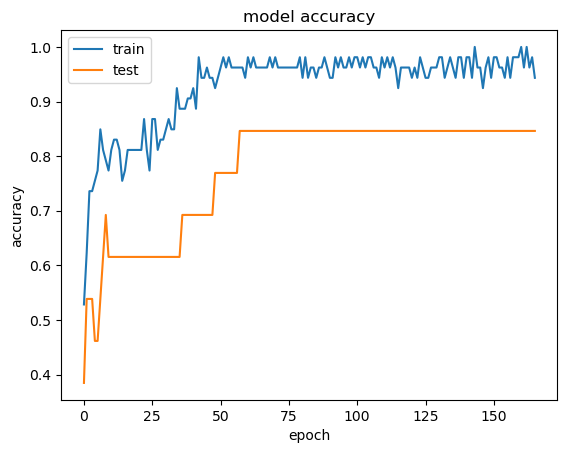

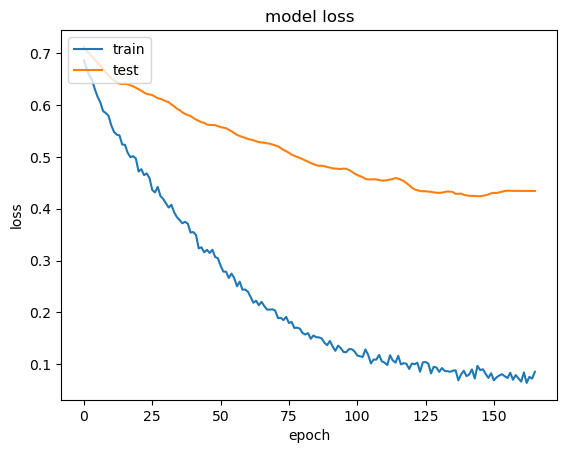

In [16]:
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
train_loss, train_acc = modeltf.evaluate(X.iloc[train_index], y[train_index])
test_loss, test_acc = modeltf.evaluate(X.iloc[test_index], y[test_index])

print("\n==============================")
print("Train Accuracy: ", train_acc)
print("Train Loss: ", train_loss)
print("==============================")
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)

1/1 [==============================] - 0s 32ms/step - loss: 0.4342 - accuracy: 0.8462

Train Accuracy:  0.9622641801834106
Train Loss:  0.0751696303486824
Test Accuracy:  0.8461538553237915
Test Loss:  0.4341922104358673


In [18]:
y_pred = modeltf.predict(X.iloc[test_index])
y_pred = (y_pred > 0.5)

1/1 [==============================] - 0s 215ms/step


In [19]:
compare_res = pd.DataFrame({
    'Y test': y[test_index],
    'Y pred': y_pred.astype(int).reshape(len(y[test_index]))
}, index=test_index)
compare_res

,Y test,Y pred
3,0,0
4,0,1
6,0,0
8,0,0
17,0,0
19,0,0
25,0,1
28,0,0
34,1,1
36,1,1


In [20]:
wrong_res_index = compare_res[compare_res['Y test'] != compare_res['Y pred']].index.values

wrong_res = data.iloc[wrong_res_index,:]
gender_pred = np.where(wrong_res['Gender']=='F', 'M', 'F')

wrong_res = wrong_res.assign(Gender_Pred = gender_pred)
wrong_res

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender,Gender_Pred
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F,M
25,Warm,R&B and soul,Whiskey,Coca Cola/Pepsi,F,M


In [21]:
data[(data.index.isin(train_index)) &
     (data['Favorite Color'] == 'Cool') &
     (data['Favorite Music Genre'] == 'Rock') &
     (data['Favorite Beverage'] == "Vodka") &
     (data['Favorite Soft Drink'] == 'Coca Cola/Pepsi')]

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
22,Cool,Rock,Vodka,Coca Cola/Pepsi,F
61,Cool,Rock,Vodka,Coca Cola/Pepsi,M


In [22]:
data[(data.index.isin(train_index)) &
     (data['Favorite Color']=='Cool') &
     (data['Favorite Music Genre'] == 'Pop') &
     (data['Favorite Beverage'] == "Whiskey") &
     (data['Favorite Soft Drink'] == 'Fanta')]

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
38,Cool,Pop,Whiskey,Fanta,M


Text(113.9222222222222, 0.5, 'Predicted Label')

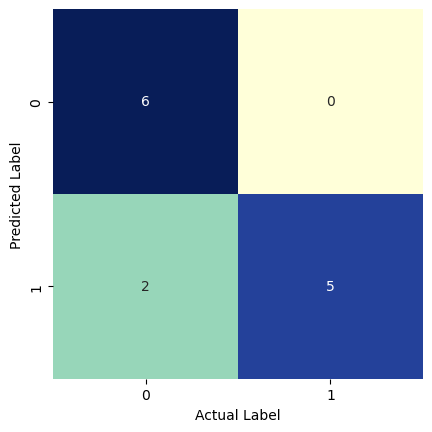

In [23]:
cm = confusion_matrix(y[test_index], y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
print("\n==============================")
print("Train Accuracy: ", train_acc)
print("Train Loss: ", train_loss)
print("==============================")
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)


Train Accuracy:  0.9622641801834106
Train Loss:  0.0751696303486824
Test Accuracy:  0.8461538553237915
Test Loss:  0.4341922104358673
